In [1]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from vis_common import load_store, load_games

FS = (10, 6) # Reasonable default figsize

DECILES = list(np.arange(0.1, 1.0, 0.1))

store = load_store()
g = games = load_games()
m = store['mutations']

In [6]:
print "{:,} rows ({:,} mutations gained, {:,} lost)".format(
    len(m), m['gained'].sum(), (~m['gained']).sum()
)

1,609,046 rows (1,301,498 mutations gained, 307,548 lost)


In [7]:
m.head()

,gained,gid,source,turn
0,True,2,potion of mutation,1576
1,True,12,potion of mutation,1970
2,True,12,potion of mutation,1970
3,True,12,potion of mutation,1970
4,True,13,demonic ancestry,413


In [8]:
m['source'].value_counts()

potion of mutation                  387490
demonic ancestry                    357045
other                               188197
potion of cure mutation             182794
mutagenic meat                      169278
species                              61213
jiyva's grace                        47072
xom's mischief                       38957
an orb of fire                       38805
a neqoxec                            38307
xom's grace                          32084
a shining eye                        26784
ru sacrifice                         22204
a cacodemon                          15671
jiyva's power                         3064
the severe capriciousness of xom        81
wand of polymorph other                  0
Name: source, dtype: int64

In [18]:
wr_prior = g['won'].mean()
# Controls the strength of the smoothing
C = 10
# TODO: This might be too generous to players who have played just one game and won it. Do they
# belong in the top 5% of players? Actually, they land in the top 2%. Median # of games played 
# among top 5% of players by smoothed wr is 20).
# Could remedy this by increasing C, or maybe even reducing prior? (Though of course this will
# have the effect of making the smoothed wr a biased estimate).

# Seems like there are maybe some more interesting things that could be done with our choice of
# prior. What about setting a prior equal to the micro-averaged mean win rate? Maybe that's dumb.
# But at a high level, it seems like we're giving something up by taking all these win counts per
# player and summing them all together to get one monolithic prior wr. Like, we can get more than
# just an estimate of the mean wr, we can also get a sense of the shape of the distribution of wrs.
# We know that it's very skewed. Should that affect how we choose a smoothed wr?
# e.g. if we knew our distribution was arcsine-like (i.e. strongly U-shaped), then wouldn't we 
# generally be better off pushing measured values closer to the extremes, rather than closer to 
# the middle?
# Also, it could be that the number of games played is a factor we could use in making our estimate?
# e.g. if we know that the overall win rate is X%, but the win rate over games played by players with
# less than 10 total games is Y <<< X%. 
# (If the above turns out to be the case, that could solve the concern about the current scheme being
# too generous to players with one win out of one game or a handful of games)
def smoothed_wr(won_col):
    return ( (won_col.sum() + (C * wr_prior))
            / (C + len(won_col)) )
smoothed_wrs = g.groupby('pid')['won'].agg(smoothed_wr)


pid
0    0.006721
1    0.003361
2    0.006721
3    0.006721
4    0.002549
Name: won, dtype: float64

In [19]:
g['wr'] = smoothed_wrs.loc[g['pid']].values


# Do newbies drink more potions of mutation / eat more mutagenic flesh?

There are a few ways we could try to measure this (assuming we have some measure of "newb-ness").

1. Compare average number of random mutation events among newbie games vs. skilled player games
    - problem: skilled player games tend to last longer. They'll therefore have more opportunities
      to gain mutations. Characters that die early probably won't even find any potions of mut
      or monsters with mutagenic flesh.
      
2. Compare mutation events *per turn* 
3. Compare mutation events among games with some minimum milestone reached
4. ???

In [19]:
# When do players drink potions of mutation?
m[m['source']=='potion of mutation']['turn'].describe()

count    387490.000000
mean      10155.560089
std       19460.558896
min           2.000000
25%        2052.000000
50%        4351.000000
75%        9710.750000
max      584480.000000
Name: turn, dtype: float64

In [2]:
( (g['turns'] >= 2000) & (g['turns'] < 4000) ).sum()

295910

In [8]:
foo = m[m['source']=='potion of mutation'].groupby(['gid', 'turn'], as_index=False).agg(lambda x: 1)
mutquaffs = foo.groupby('gid').size()
mutquaffs.head()
g['poms'] = mutquaffs
g['poms'].fillna(0, inplace=True)

gid
2     1
12    1
21    1
31    2
39    1
dtype: int64

In [17]:
print "{:,} potions of mutation quaffed over {:,} games (avg. {:.2f} per game)".format(
    mutquaffs.sum(), len(g), mutquaffs.sum()/len(g)
)

149,568 potions of mutation quaffed over 1,326,162 games (avg. 0.11 per game)


In [21]:
(100*g['wr']).describe(DECILES)

count    1.326162e+06
mean     7.398727e-01
std      2.132121e+00
min      1.564103e-03
10%      8.940164e-03
20%      2.014582e-02
30.0%    3.850790e-02
40%      7.178171e-02
50%      1.320271e-01
60%      2.385005e-01
70%      4.589466e-01
80%      7.670965e-01
90%      1.727191e+00
max      6.459563e+01
Name: wr, dtype: float64

In [53]:
#g['decile'] = pd.qcut(g['wr'], q=10)
g['decile'] = pd.qcut(g['wr'], 
    q=[0, .25, .5, .75, .9, .95, 1.],
    labels=['25%', '50%', '75%', '90%', '95%', '100%'],
)

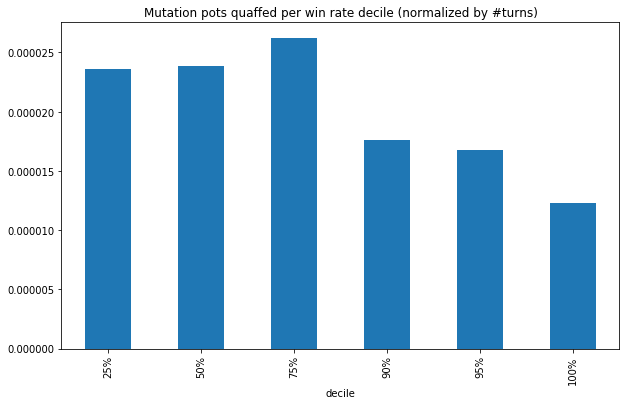

In [54]:
foo = g.groupby('decile')[['poms', 'turns']]
bar = foo.apply(lambda x: x['poms'].sum() / x['turns'].sum())
bar.plot.bar(figsize=FS, title="Mutation pots quaffed per win rate decile (normalized by #turns)");

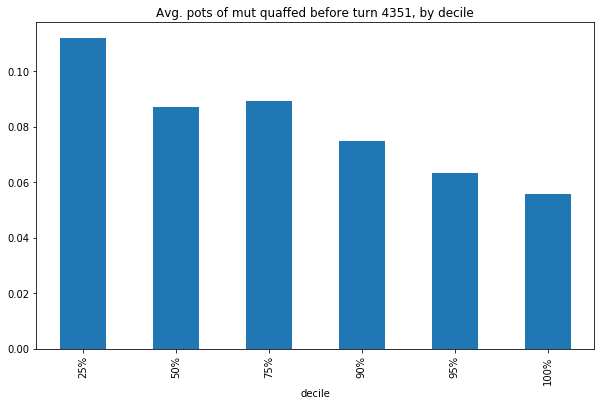

In [55]:
# Alternative metric: of games lasting at least N turns, avg. number of mut pots quaffed before turn N?
turn_thresh = 4351 # Median quaff turn

mutquaffs = m[(m['source']=='potion of mutation') & (m['turn'] <= turn_thresh)]\
    .groupby(['gid', 'turn'], as_index=False).agg(lambda x: 1)\
    .groupby('gid').size()
g['poms'] = mutquaffs
g['poms'].fillna(0, inplace=True)

g[g['turns'] > turn_thresh].groupby('decile')['poms']\
    .apply(lambda x: x.sum() / len(x) )\
    .plot.bar(figsize=FS, title="Avg. pots of mut quaffed before turn 4351, by decile");

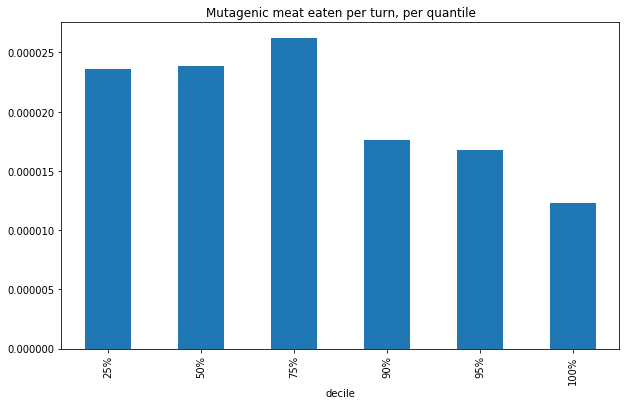

In [56]:
# Now with mutagenic meat
mutquaffs = m[(m['source']=='mutagenic meat')]\
    .groupby(['gid', 'turn'], as_index=False).agg(lambda x: 1)\
    .groupby('gid').size()
g['poms'] = mutquaffs
g['poms'].fillna(0, inplace=True)

g.groupby('decile')[['poms', 'turns']].apply(lambda x: x['poms'].sum() / x['turns'].sum())\
    .plot.bar(figsize=FS, title='Mutagenic meat eaten per turn, per quantile');

In [57]:
g['decile'].cat.categories

Index([u'25%', u'50%', u'75%', u'90%', u'95%', u'100%'], dtype='object')

In [49]:
worst = 8.94e-05
gworst = g[g['wr'] <= worst]
print "Bottom decile contains {} players with {} total wins.".format(
    len(gworst['pid'].unique()), gworst['won'].sum()
)
print "\nDist of games played..."
gworst.groupby('pid').size().describe()

Bottom decile contains 89 players with 0 total wins.

Dist of games played...


count      89.000000
mean     1487.887640
std       789.694006
min       819.000000
25%      1006.000000
50%      1204.000000
75%      1661.000000
max      4717.000000
dtype: float64

In [58]:
# How many distinct players per decile?
g.groupby('decile').apply(lambda gr: len(gr['pid'].unique()))

decile
25%       533
50%      2336
75%      9807
90%     12250
95%       382
100%      696
dtype: int64

In [44]:
# How many long-enough games per decile?
g.groupby('decile').apply(lambda grp: (grp['turns'] > turn_thresh).sum() )

decile
[1.56e-05, 8.94e-05]    29362
(8.94e-05, 0.000201]    29689
(0.000201, 0.000385]    32469
(0.000385, 0.000718]    33151
(0.000718, 0.00132]     34577
(0.00132, 0.00239]      34792
(0.00239, 0.00459]      37706
(0.00459, 0.00767]      38991
(0.00767, 0.0173]       49906
(0.0173, 0.646]         58793
dtype: int64

In [63]:
# Median # of games played per decile
g.groupby('decile').apply(lambda gr: gr.groupby('pid').size().median())

decile
25%     622.185741
50%     142.200342
75%      33.780157
90%      16.262612
95%     173.010471
100%     94.494253
dtype: float64

In [69]:
g[g['wr'] > g['wr'].quantile(.99)].groupby('pid').size().describe()

count    128.000000
mean      99.640625
std      153.387048
min        3.000000
25%       15.000000
50%       41.000000
75%      113.500000
max      810.000000
dtype: float64

**TODO**: maybe use non-uniform quantiles? Probably want more differentiation at the top end,
less at the bottom end?